## Text Classification and Sentiment Analysis

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string,re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [19]:
df = pd.read_csv('amazonreviews.tsv',sep="\t")
df.shape

(10000, 2)

In [20]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [21]:
print("\nColumns:", df.columns.tolist())
print("\nLabel distribution:")
print(df["label"].value_counts())



Columns: ['label', 'review']

Label distribution:
label
neg    5097
pos    4903
Name: count, dtype: int64


## Data Cleaning: Remove duplicates, handle missing reviews if any, preprocess text (lowercasing, stopwords removal).

In [22]:
# Remove duplicates
before = df.shape[0]
df = df.drop_duplicates(subset=["review"])
after = df.shape[0]
print(f"Removed {before - after} duplicate reviews.")


Removed 0 duplicate reviews.


In [23]:
 ## Handle missing values
print("\nMissing values before:")
print(df.isnull().sum())

df = df.dropna(subset=["review", "label"])

print("\nMissing values after:")
print(df.isnull().sum())


Missing values before:
label     0
review    0
dtype: int64

Missing values after:
label     0
review    0
dtype: int64


In [24]:
## Basic text preprocessing function
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)
    # Remove digits
    text = re.sub(r"\d+", " ", text)
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize and remove stopwords
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    # Join back
    return " ".join(tokens)
# Apply cleaning
df["clean_review"] = df["review"].astype(str).apply(clean_text)

print("\nSample cleaned reviews:")
display(df[["review", "clean_review"]].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Sample cleaned reviews:


,review,clean_review
0,Stuning even for the non-gamer: This sound tra...,stuning even nongamer sound track beautiful pa...
1,The best soundtrack ever to anything.: I'm rea...,best soundtrack ever anything im reading lot r...
2,Amazing!: This soundtrack is my favorite music...,amazing soundtrack favorite music time hands i...
3,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack truly like soundtrack enj...
4,"Remember, Pull Your Jaw Off The Floor After He...",remember pull jaw floor hearing youve played g...


## Exploratory Analysis: Word clouds, sentiment distribution, most common positive/negative words.

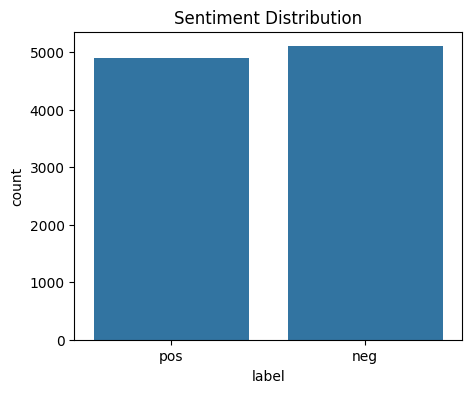

In [25]:
from wordcloud import WordCloud

# Sentiment distribution
plt.figure(figsize=(5,4))
sns.countplot(x="label", data=df)
plt.title("Sentiment Distribution")
plt.show()

# Separate positive and negative reviews
pos_text = " ".join(df.loc[df["label"] == "pos", "clean_review"])
neg_text = " ".join(df.loc[df["label"] == "neg", "clean_review"])

# Word cloud for positive reviews
pos_wc = WordCloud(width=800, height=400, background_color="white").generate(pos_text)
neg_wc = WordCloud(width=800, height=400, background_color="white").generate(neg_text)


In [26]:
# Most common words (quick frequency count)
from collections import Counter

def get_top_n_words(texts, n=20):
    all_words = " ".join(texts).split()
    counter = Counter(all_words)
    return counter.most_common(n)

print("\nTop 20 words in positive reviews:")
print(get_top_n_words(df.loc[df["label"] == "pos", "clean_review"]))

print("\nTop 20 words in negative reviews:")
print(get_top_n_words(df.loc[df["label"] == "neg", "clean_review"]))



Top 20 words in positive reviews:
[('book', 3313), ('great', 2087), ('one', 1835), ('good', 1634), ('read', 1553), ('like', 1268), ('movie', 1085), ('would', 943), ('love', 904), ('time', 872), ('well', 854), ('really', 828), ('best', 801), ('get', 793), ('story', 713), ('first', 708), ('much', 650), ('cd', 581), ('music', 560), ('also', 557)]

Top 20 words in negative reviews:
[('book', 3184), ('one', 2022), ('like', 1547), ('movie', 1465), ('would', 1438), ('dont', 1240), ('read', 1187), ('get', 1139), ('good', 1134), ('time', 1035), ('even', 898), ('buy', 814), ('really', 778), ('much', 769), ('bad', 749), ('money', 745), ('first', 736), ('could', 658), ('better', 656), ('great', 633)]


In [27]:
## Feature Extraction using TF-IDF

# Encode label: pos -> 1, neg -> 0
y = df["label"].map({"pos": 1, "neg": 0}).values
X_text = df["clean_review"].values

# Train-test split
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=20000,ngram_range=(1,2),min_df=3)
tfidf


TfidfVectorizer(max_features=20000, min_df=3, ngram_range=(1, 2))

In [28]:
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape :", X_test_tfidf.shape)


TF-IDF train shape: (8000, 20000)
TF-IDF test shape : (2000, 20000)


## Model Development: Use NLP techniques (TF-IDF, Word2Vec, or BERT embeddings) with models like Logistic Regression, SVM, or Neural Networks.

In [29]:
## Model Development – Logistic Regression baseline

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg

LogisticRegression(max_iter=1000, n_jobs=-1)

In [30]:
# Train model
log_reg.fit(X_train_tfidf, y_train)

# Predictions
y_pred = log_reg.predict(X_test_tfidf)
y_pred

array([0, 1, 0, ..., 0, 1, 0])


=== Logistic Regression (TF-IDF) ===
Accuracy : 0.8565
Precision: 0.8548057259713702
Recall   : 0.8521916411824668
F1-score : 0.8534966819806024

Classification report:
              precision    recall  f1-score   support

         neg       0.86      0.86      0.86      1019
         pos       0.85      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



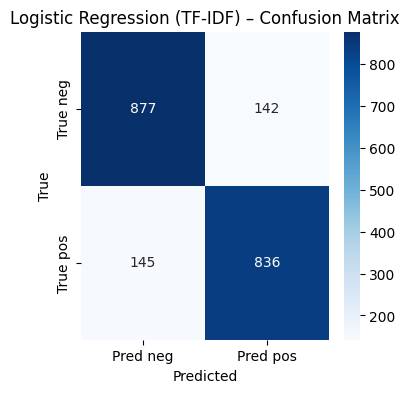

In [31]:
# Evaluation (Task 4)
def evaluate(y_true, y_pred, name="Model"):
    print(f"\n=== {name} ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, target_names=["neg", "pos"]))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Pred neg", "Pred pos"],
                yticklabels=["True neg", "True pos"])
    plt.title(f"{name} – Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

evaluate(y_test, y_pred, name="Logistic Regression (TF-IDF)")


## Validation: Use train/test split, cross-validation, and metrics like accuracy, F1-score.

In [32]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Use a smaller subset of features if memory is an issue
svm_clf = LinearSVC()
svm_clf


LinearSVC()

SVM 5-fold F1 scores: [0.85549872 0.85425868 0.87247475 0.85603113 0.85057471]
SVM mean F1: 0.8577675969659161

=== Linear SVM (TF-IDF) ===
Accuracy : 0.857
Precision: 0.854230377166157
Recall   : 0.854230377166157
F1-score : 0.854230377166157

Classification report:
              precision    recall  f1-score   support

         neg       0.86      0.86      0.86      1019
         pos       0.85      0.85      0.85       981

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



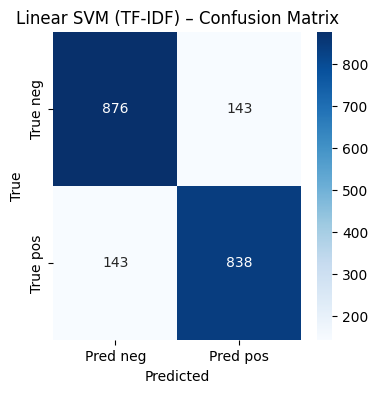

In [33]:
# Cross-validation on training set
cv_scores = cross_val_score(svm_clf, X_train_tfidf, y_train, cv=5, scoring='f1')
print("SVM 5-fold F1 scores:", cv_scores)
print("SVM mean F1:", cv_scores.mean())

# Train final SVM model
svm_clf.fit(X_train_tfidf, y_train)
y_pred_svm = svm_clf.predict(X_test_tfidf)

evaluate(y_test, y_pred_svm, name="Linear SVM (TF-IDF)")
